In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels
from all_models import *

In [2]:
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))/90.0

In [3]:
fits_single = pickle.load(open('fit_single_CV_640_bestfit_starting_point.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_640_bestfit_starting_point.pickle', 'rb'))

In [176]:
single_win = np.zeros((100, 60))
for i in range(100):
    for participant in range(60):
        single_win[i][participant] =  np.around(fits_single[i][participant, -3], 0) < np.around(fits_dual[i][participant, -3], 0)

In [178]:
np.where(np.sum(single_win, axis = 0) > 59)

(array([18, 22, 26, 29, 44, 45, 48, 50, 51, 54, 58], dtype=int64),)

In [198]:
l = list()
for j in range (100):
    for i in np.where(np.sum(single_win, axis = 0) > 59)[0]:
        l.append((fits_single[j][i][-3] - fits_dual[j][i][-3]) / fits_single[j][i][-3])

In [200]:
max(l)

0.022925786146839426

# Generating Train-Test splits

In [72]:
model_errors_single = np.zeros((100, 60, 640))
model_errors_dual = np.zeros((100, 60, 640))

for i in range(100):
    for participant in range(60):
        if participant%4 == 0  or participant%4 == 1:
            model_errors_single[i][participant] = model_sudden(640, A=fits_single[i][participant][0], B = fits_single[i][participant][1])[0]
            model_errors_dual[i][participant] = dual_model_sudden(640, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            
        else:
            model_errors_single[i][participant] = model_gradual(640, A=fits_single[i][participant][0], B = fits_single[i][participant][1])[0]
            model_errors_dual[i][participant] = dual_model_gradual(640, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]


In [98]:
single_train_neg2ll = np.zeros((100, 60))
single_test_neg2ll = np.zeros((100, 60))
dual_train_neg2ll = np.zeros((100, 60))
dual_test_neg2ll = np.zeros((100, 60))

for i in range(100):
    for participant in range(60):
        total_neg2ll = -2*stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:-1]), model_errors_single[i][participant], fits_single[i][participant][-2])
        single_train_neg2ll[i][participant] = sum(np.take(total_neg2ll, fits_single[i][participant][-1][fits_single[i][participant][-1] < 640]))
        single_test_neg2ll[i][participant] = sum(total_neg2ll) - single_train_neg2ll[i][participant]

        total_neg2ll = -2*stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:-1]), model_errors_dual[i][participant], fits_dual[i][participant][-2])
        dual_train_neg2ll[i][participant] = sum(np.take(total_neg2ll, fits_dual[i][participant][-1][fits_dual[i][participant][-1] < 640]))
        dual_test_neg2ll[i][participant] = sum(total_neg2ll) - dual_train_neg2ll[i][participant]
        

In [232]:
group = 2
sum(sum(dual_test_neg2ll[:, group::4] < single_test_neg2ll[:, group::4]) > 59)

3

In [220]:
group = 3
sum(sum(dual_train_neg2ll[:, group::4] < single_train_neg2ll[:, group::4]) > 59)

11

In [238]:
np.where(np.sum(dual_test_neg2ll < single_test_neg2ll, axis = 0) > 59)[0]

(array([ 1,  3,  4,  5,  7,  8,  9, 12, 13, 15, 16, 17, 20, 21, 23, 25, 28,
        31, 32, 33, 35, 37, 38, 39, 41, 42, 43, 46, 47, 49, 52, 53, 56, 57,
        59], dtype=int64),)

In [263]:
for i in np.where(np.sum(dual_test_neg2ll < single_test_neg2ll, axis = 0) < 59)[0]:
    for j in range(100):
        l.append((single_test_neg2ll[j][i] - dual_test_neg2ll[j][i]))

(array([5.200e+01, 1.110e+03, 3.324e+03, 1.740e+02, 1.080e+02, 2.400e+01,
        4.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([-1.00132642, -0.54874609, -0.09616575,  0.35641458,  0.80899492,
         1.26157525,  1.71415558,  2.16673592,  2.61931625,  3.07189658,
         3.52447692]),
 <BarContainer object of 10 artists>)

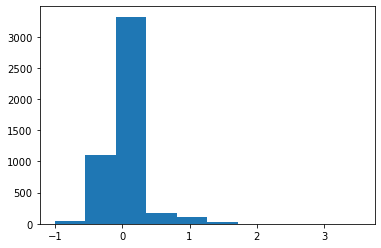

In [264]:
plt.hist(l)